# Deep Convolutinal Networks (DCN)

### Step 1 - Import libraries

In [8]:
# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.


# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # for showing images
print('matplotlib: %s' % matplotlib.__version__) # print version

#GUI
import tkinter as tk
from tkinter import filedialog
from turtle import title
from tkinter import *
from PIL import ImageTk, Image

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.9.0
pandas: 1.4.2
numpy: 1.22.4
sklearn: 1.1.1
OpenCV: 4.5.5
matplotlib: 3.5.2


### Step 2 - Load and Process Caltech101 image dataset
- Source and Licence: http://www.vision.caltech.edu/Image_Datasets/Caltech101/
- Required Refrence: L. Fei-Fei, R. Fergus and P. Perona. Learning generative visual models from few training examples: an incremental Bayesian approach tested on 101 object categories. IEEE. CVPR 2004, Workshop on Generative-Model Based Vision. 2004

In [9]:
# Specify the location of images after you have downloaded them
ImgLocation=main_dir+"/data/101_ObjectCategories/"

# List image categories we are interested in
LABELS = set(["dalmatian", "hedgehog", "llama", "panda"])

# Create two lists to contain image paths and image labels
ImagePaths=[]
ListLabels=[]
for label in LABELS:
    for image in list(os.listdir(ImgLocation+label)):
        ImagePaths=ImagePaths+[ImgLocation+label+"/"+image]
        ListLabels=ListLabels+[label]
        
# Load images and resize to be a fixed 128x128 pixels, ignoring original aspect ratio
data=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.resize(image, (128, 128))
    data.append(image)
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data = np.array(data, dtype="float") / 255.0

# Show data shape
print("Shape of whole data: ", data.shape)

# Convert Labels list to numpy array
LabelsArray=np.array(ListLabels)

# Encode labels 
enc = OrdinalEncoder()
y=enc.fit_transform(LabelsArray.reshape(-1,1))


# ---- Create training and testing samples ---
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

# Print shapes
# Note, model input must have a four-dimensional shape [samples, rows, columns, channels]
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of whole data:  (237, 128, 128, 3)
Shape of X_train:  (189, 128, 128, 3)
Shape of y_train:  (189, 1)
Shape of X_test:  (48, 128, 128, 3)
Shape of y_test:  (48, 1)


##### Display a few images from our the training dataset

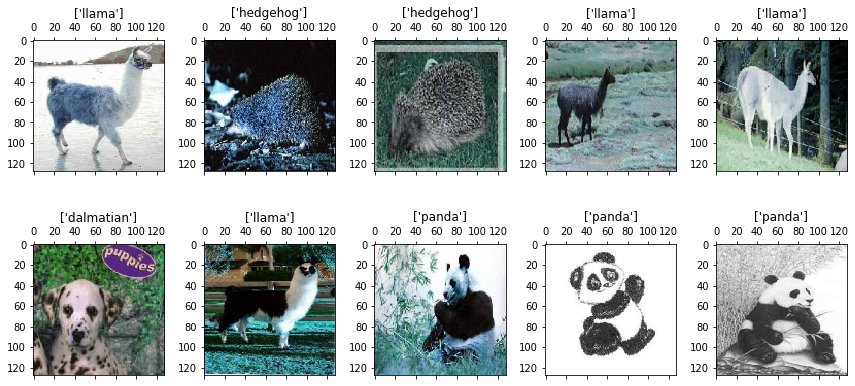

In [10]:
# Display images of 10 animals in the training set and their true labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=enc.inverse_transform(y_train)[n])
        n=n+1
plt.show() 

### Step 3 - Train a Deep Convolutional Neural Network

From Tensorflow Keras Documentation (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout):
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [11]:
##### Step 1 - Specify the structure of a Neural Network
#--- Define a Model
model = Sequential(name="DCN-Model") # Model


#--- Input Layer 
# Specify input shape [rows, columns, channels]
model.add(Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs


#--- First Set of Convolution, Max Pooling and Droput Layers (all parameters shown)
model.add(Conv2D(filters=16, # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
                kernel_size=(3,3), # An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
                strides=(1,1), # Default=(1,1), An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
                padding='valid', # Default='valid', "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
                data_format=None, # Default=None, A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch_size, height, width, channels) while channels_first corresponds to inputs with shape (batch_size, channels,height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be channels_last.
                dilation_rate=(1, 1), # Default=(1, 1), an integer or tuple/list of 2 integers, specifying the dilation rate to use for dilated convolution. Can be a single integer to specify the same value for all spatial dimensions. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any stride value != 1.
                groups=1, # Default=1, A positive integer specifying the number of groups in which the input is split along the channel axis. Each group is convolved separately with filters / groups filters. The output is the concatenation of all the groups results along the channel axis. Input channels and filters must both be divisible by groups.
                activation='relu', # Default=None, Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
                use_bias=True, # Default=True. 
                kernel_initializer='glorot_uniform', # Default='glorot_uniform', Initializer for the kernel weights matrix (see keras.initializers).
                bias_initializer='zeros', # Default='zeros', Initializer for the bias vector (see keras.initializers).
                kernel_regularizer=None, # Default=None, Regularizer function applied to the kernel weights matrix (see keras.regularizers).
                bias_regularizer=None, # Default=None, Regularizer function applied to the bias vector (see keras.regularizers).
                activity_regularizer=None, # Default=None, Regularizer function applied to the output of the layer (its "activation") (see keras.regularizers).
                kernel_constraint=None, # Default=None, Constraint function applied to the kernel matrix (see keras.constraints).
                bias_constraint=None, # Default=None, Constraint function applied to the bias vector (see keras.constraints).
                name='2D-Convolutional-Layer-1') # Name of the layer (optional)
        ) # Convolutional Layer, relu activation used

model.add(MaxPool2D(pool_size=(2,2), # Default=(2,2), integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window. If only one integer is specified, the same window length will be used for both dimensions.
                strides=(2,2), # Default=None, Integer, tuple of 2 integers, or None. Strides values. Specifies how far the pooling window moves for each pooling step. If None, it will default to pool_size.
                padding='valid', # Default='valid', One of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
                data_format=None, # Default=None, A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, height, width, channels) while channels_first corresponds to inputs with shape (batch, channels, height, width). 
                name='2D-MaxPool-Layer-1')
        ) # Max Pooling Layer,

model.add(Dropout(0.2, name='Dropout-Layer-1')) # Dropout Layer


#--- Second Set of Convolution, Max Pooling and Droput Layers 
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', name='2D-Convolutional-Layer-2')) # Convolutional Layer
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='2D-MaxPool-Layer-2')) # Second Max Pooling Layer,
model.add(Dropout(0.2, name='Dropout-Layer-2')) # Dropout Layer


#--- Third Set of Convolution, Max Pooling and Droput Layers
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='2D-Convolutional-Layer-3')) # Convolutional Layer
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same', name='2D-MaxPool-Layer-3')) # Second Max Pooling Layer,
model.add(Dropout(0.2, name='Dropout-Layer-3')) # Dropout Layer


#--- Feed-Forward Densely Connected Layer and Output Layer (note, flattening is required to convert from 2D to 1D shape)
model.add(Flatten(name='Flatten-Layer')) # Flatten the shape so we can feed it into a regular densely connected layer
model.add(Dense(16, activation='relu', name='Hidden-Layer-1', kernel_initializer='HeNormal')) # Hidden Layer, relu(x) = max(x, 0)
model.add(Dense(4, activation='softmax', name='Output-Layer')) # Output Layer, softmax(x) = exp(x) / tf.reduce_sum(exp(x))


In [12]:
##### Step 2 - Compile keras model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
        loss='SparseCategoricalCrossentropy', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
        metrics=['Accuracy'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
        loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
        weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
        run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
        steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
    )


##### Step 3 - Fit keras model on the dataset
history = model.fit(X_train, # input data
                    y_train, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.0, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=False, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                )


##### Step 4 - Use model to make predictions
# Note, we need to pass model output through argmax to convert from probability to label
# Also, we convert output from tensor to numpy array
# Predict class labels on training data
pred_labels_tr = np.array(tf.math.argmax(model.predict(X_train),axis=1))
# Predict class labels on a test data
pred_labels_te = np.array(tf.math.argmax(model.predict(X_test),axis=1))


##### Step 5 - Model Performance Summary
print("")
print('------------------------- Model Summary -------------------------')
model.summary() # print model summary
print("")
    
print("")
print('------------------------- Encoded Names -------------------------')
for i in range(0,len(enc.categories_[0])):
    print(i,": ",enc.categories_[0][i])
print("")

print('------------------ Evaluation on Training Data ------------------')
# Print the last value in the evaluation metrics contained within history file
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")
# Print classification report
print(classification_report(y_train, pred_labels_tr))
print("")

print('-------------------- Evaluation on Test Data --------------------')
print(classification_report(y_test, pred_labels_te))
print("")

Epoch 1/20
189/189 [==============================] - 3s 15ms/step - loss: 1.3923 - Accuracy: 0.3069
Epoch 2/20
189/189 [==============================] - 3s 16ms/step - loss: 1.4195 - Accuracy: 0.3228
Epoch 3/20
189/189 [==============================] - 3s 16ms/step - loss: 1.3786 - Accuracy: 0.3280
Epoch 4/20
189/189 [==============================] - 3s 15ms/step - loss: 1.3366 - Accuracy: 0.3492
Epoch 5/20
189/189 [==============================] - 3s 16ms/step - loss: 1.2480 - Accuracy: 0.3968
Epoch 6/20
189/189 [==============================] - 3s 15ms/step - loss: 1.1673 - Accuracy: 0.4815
Epoch 7/20
189/189 [==============================] - 3s 16ms/step - loss: 0.9614 - Accuracy: 0.6085
Epoch 8/20
189/189 [==============================] - 3s 16ms/step - loss: 0.7477 - Accuracy: 0.7090
Epoch 9/20
189/189 [==============================] - 3s 16ms/step - loss: 0.3932 - Accuracy: 0.8730
Epoch 10/20
189/189 [==============================] - 3s 15ms/step - loss: 0.2825 - Accura

### Step 3 - Check which category the model will put my dog in

##### Ingest the image

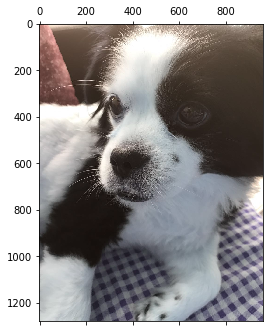

In [13]:
# Read in the image
mydog = cv2.imread(main_dir+"/data/mydog.JPG")

# Display the image
plt.matshow(mydog)
plt.show()

border_effects = {
  
    "raised": tk.RAISED,
    
}

window = tk.Tk()
window.geometry('800x600')
window.title('Flower Recognition')
window.configure(background='#CDCDCD')
window.columnconfigure(0, minsize=250)
window.rowconfigure([0, 1], minsize=100)

label = tk.Label(window, background='#CDCDCD', font=('arial', 15, 'bold'))
sign_image = tk.Label(window)

for relief_name, relief in border_effects.items():
    frame = tk.Frame(master=window, relief=relief, bg="light blue")
    frame.pack(fill=tk.X)
    label = tk.Label(master=frame, text="CHOOSE AN IMAGE", bg="light blue", justify =['center'], padx=200, pady=150, font=('arial', 30, 'bold'))
    label.grid()

def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((30, 30))
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    print(image.shape)
   

def show_classify_button(file_path):
    classify_b = Button(window, text="Classify Image", command=lambda: classify(file_path), padx=10, pady=5)
    classify_b.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
    classify_b.place(relx=0.79, rely=0.46)
  
def upload_image():
    file_path = filedialog.askopenfilename()
    uploaded = Image.open(file_path)
    uploaded.thumbnail(((window.winfo_width() / 2.25), (window.winfo_height() / 2.25)))
       

button = tk.Button(frame, text="SELECT AN IMAGE", fg="black",justify =['center'], command=upload_image, padx=10, pady=15, font=('arial', 11, 'bold'))
button.grid()

frame1 = tk.Frame(master=window, height=900, bg="light blue")
frame1.pack(fill=tk.X)
window.mainloop()



##### Prep the image and make a prediction using our model

In [ ]:
# Resize 
mydog = cv2.resize(mydog, (128, 128))

# Standardize (divide by 255 since RGB values ranges from 0 to 255)
mydog = mydog / 255.0

# The current shape of mydog array is [rows, columns, channels].
# Add extra dimension to make it [samples, rows, columns, channels] that is required by the model
mydog = mydog[np.newaxis, ...]

# Print shape
print("Shape of the input: ", mydog.shape)
print("")

#----- Predict label of mydog image -----
# Note, we need to pass model output through argmax to convert from probability to label
# Also, we convert output from tensor to numpy array
# Finally, we do inverse transform to convert from encoded value to categorical label
pred_mydog = enc.inverse_transform(np.array(tf.math.argmax(model.predict(mydog),axis=1)).reshape(-1, 1))
print("DCN model prediction: ", pred_mydog)


#----- Show Probabilities of each prediction -----
pred_probs=model.predict(mydog)

# Print in a nice format with label and probability next to each other
print("")
print("Probabilities for each category:")
for i in range(0,len(enc.categories_[0])):
    print(enc.categories_[0][i], " : ", pred_probs[0][i])

### End of Program